 Reproduction of the experiment from Figure 1(a) in Bader et al. (2007) on a random undirected graph G(2000, 7980).

[info] Graph not connected. Using GCC with n=1999, m=7980
[graph] n=1999, m=7980
[approx] max BFS samples = 99 (n/20)
[approx] BFS 10/99 done
[approx] BFS 20/99 done
[approx] BFS 30/99 done
[approx] BFS 40/99 done
[approx] BFS 50/99 done
[approx] BFS 60/99 done
[approx] BFS 70/99 done
[approx] BFS 80/99 done
[approx] BFS 90/99 done
[approx] BFS 99/99 done
[approx] finished in 0.33s
[exact] finished in 5.79s


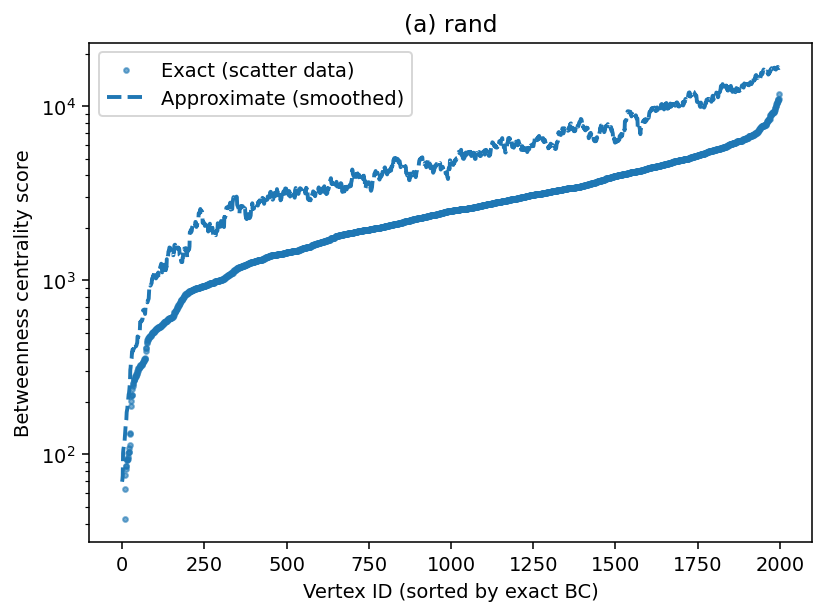

In [2]:
import random
from collections import deque

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from time import perf_counter


# generate a random G(n, m) graph and return its GCC
def make_gnm_graph(n=2000, m=7980, seed=42):
    G = nx.gnm_random_graph(n, m, seed=seed, directed=False)
    if not nx.is_connected(G):
        GCC_nodes = max(nx.connected_components(G), key=len)
        G = G.subgraph(GCC_nodes).copy()
        print(f"[info] Graph not connected. Using GCC with n={G.number_of_nodes()}, m={G.number_of_edges()}")
    return G


# Brandes' single-source dependencies calculation for unweighted graphs
def brandes_single_source_dependencies_unweighted(G, s):
    S = []                         
    P = {v: [] for v in G}         
    sigma = dict.fromkeys(G, 0.0) 
    dist  = dict.fromkeys(G, -1)  

    sigma[s] = 1.0
    dist[s]  = 0
    Q = deque([s])

    # BFS phase
    while Q:
        v = Q.popleft()
        S.append(v)
        for w in G[v]:
            if dist[w] < 0:
                dist[w] = dist[v] + 1
                Q.append(w)
            if dist[w] == dist[v] + 1:
                sigma[w] += sigma[v]
                P[w].append(v)

    # Back-propagation of dependencies δ_s(.)
    delta = dict.fromkeys(G, 0.0)
    while S:
        w = S.pop()
        for v in P[w]:
            if sigma[w] != 0:
                delta[v] += (sigma[v] / sigma[w]) * (1.0 + delta[w])
    return delta


# approximate BC via Algorithm 1 with cut-off n/20
def approx_bc_algorithm1_cutoff(G, c=5.0, cutoff_factor=20, seed=0):

    rng = random.Random(seed)
    nodes = list(G.nodes())
    n = len(nodes)

    max_samples = max(1, n // cutoff_factor)  #  n/20 as cut-off in Figure 1 in the paper
    print(f"[approx] max BFS samples = {max_samples} (n/{cutoff_factor})")

    S = {v: 0.0 for v in nodes} 
    k = {v: 0   for v in nodes}  

    t0 = perf_counter()
    for i in range(max_samples):
        s = rng.choice(nodes)
        delta = brandes_single_source_dependencies_unweighted(G, s)

        for v in nodes:
            if v == s:
                continue
            S[v] += delta[v]
            k[v] += 1

        if (i+1) % 10 == 0 or i+1 == max_samples:
            print(f"[approx] BFS {i+1}/{max_samples} done")

    t1 = perf_counter()
    print(f"[approx] finished in {t1 - t0:.2f}s")

    # Estimate BC: use each v's own k[v]
    bc_hat = {v: (n * S[v] / k[v]) if k[v] > 0 else 0.0 for v in nodes}
    return bc_hat



def smooth_series(y, window=51):
    w = max(3, int(window))
    if w % 2 == 0:
        w += 1
    if w > len(y):
        w = len(y) if len(y) % 2 == 1 else len(y) - 1
        if w < 3:
            return np.array(y, dtype=float)
    kernel = np.ones(w) / w
    ypad = np.pad(y, (w // 2, w // 2), mode="edge")
    ys = np.convolve(ypad, kernel, mode="valid")
    return ys



def main():
    # generate a random graph graph
    G = make_gnm_graph(n=2000, m=7980, seed=42)
    print(f"[graph] n={G.number_of_nodes()}, m={G.number_of_edges()}")

    # Approximate: Algorithm 1 + cut-off n/20
    approx_bc = approx_bc_algorithm1_cutoff(G, c=5.0, cutoff_factor=20, seed=0)

    # exact BC
    t2 = perf_counter()
    exact_bc = nx.betweenness_centrality(G, normalized=False)
    t3 = perf_counter()
    print(f"[exact] finished in {t3 - t2:.2f}s")

    # Sort by exact BC, corresponding to Figure 1's x-axis "Vertex ID (sorted by BC)"
    nodes_sorted = sorted(exact_bc.keys(), key=lambda v: exact_bc[v])
    x = np.arange(len(nodes_sorted))
    y_exact = np.array([exact_bc[v] for v in nodes_sorted], dtype=float)
    y_approx = np.array([approx_bc[v] for v in nodes_sorted], dtype=float)

    # smooth
    y_smoothed = smooth_series(y_approx, window=max(31, len(y_approx) // 50))

    # exact scatter + approx smoothed plot
    plt.figure(figsize=(6, 4.5), dpi=140)
    plt.scatter(x, y_exact, s=6, alpha=0.6, label="Exact (scatter data)")
    plt.plot(x, y_smoothed, linestyle="--", linewidth=2, label="Approximate (smoothed)")
    plt.yscale("log")
    plt.xlabel("Vertex ID (sorted by exact BC)")
    plt.ylabel("Betweenness centrality score")
    plt.title("(a) rand")
    plt.legend()
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()